In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import os

In [2]:
def Save_Var(data, save_name):
    with open(str(save_name + ".data"), 'wb') as f:
        pickle.dump(data, f)
        
    try:
        with open(str(save_name + ".data"), 'rb') as f:
            new_data = pickle.load(f)
    except:
        print("Error: saving not successful")
    else:
        print(str(save_name + ".data" + " saved succesfully"))

def Load_Var(save_name):
    with open(save_name, 'rb') as f:
        data = pickle.load(f)
    return data 

In [3]:
def Examine_Nulls(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    return missing_value_df

## Load Data

In [4]:
DS = xr.open_dataset('SCDNA_v1.1.nc4')

In [5]:
DS

<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nday: 14610, nsf: 3, nstn: 27276)
Dimensions without coordinates: lle, nchar, nday, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (nday) int32 ...
    sflag      (nsf, nstn) |S1 ...
    prcp       (nstn, nday) float32 ...
    prcp_flag  (nstn, nday) float64 ...
    prcp_kge   (nstn) float32 ...
    tmin       (nstn, nday) float32 ...
    tmin_flag  (nstn, nday) float64 ...
    tmin_kge   (nstn) float32 ...
    tmax       (nstn, nday) float32 ...
    tmax_flag  (nstn, nday) float64 ...
    tmax_kge   (nstn) float32 ...

In [6]:
IDs = DS.ID.values.astype(str)
stationid = [c2+c3+c4+c5+c6+c7+c8+c9+c10+c11+c12 for (c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12)\
           in zip(IDs[2,:],IDs[3,:],IDs[4,:],IDs[5,:],IDs[6,:],IDs[7,:],IDs[8,:],IDs[9,:],IDs[10,:],\
                  IDs[11,:],IDs[12,:])]
sources = [c0+c1 for (c0,c1) in zip(IDs[0,:],IDs[1,:])]
oid = [source+sid for (source,sid) in zip(sources,stationid)]

In [7]:
np.unique(stationid)

array(['69014093101', '69015093121', '69016093114', ..., 'VQC00679450',
       'VQW00011624', 'VQW00011640'], dtype='<U11')

In [8]:
np.unique(sources)

array(['EC', 'GH', 'GS', 'ME', 'MR'], dtype='<U2')

#### Modify XArray object for easier conversion to a Dataframe

In [9]:
dates = [datetime.strptime(str(date),'%Y%m%d') for date in DS.date.values]
DS = DS.set_coords(['date','ID'])
DS = DS.assign_coords(nstn = oid, nday = dates)

In [10]:
DS.coords['latitude'] = DS.LLE[0,:]
DS.coords['longitude'] = DS.LLE[1,:]
DS.coords['elevation'] = DS.LLE[2,:]

In [11]:
# IDS = DS.ID.values.astype(str)
# DS.coords['source'] = DS['nstn'].str[0:2]
# DS.coords['ID'] = DS['nstn'].str[2:]

In [12]:
DS = DS.drop_dims(['lle'])
DS = DS.drop_vars("date")
DS = DS.rename_dims(nstn='station', nday='datetime')
DS = DS.rename_vars(nstn='station', nday='datetime')

In [13]:
DS

<xarray.Dataset>
Dimensions:    (datetime: 14610, nchar: 13, nsf: 3, station: 27276)
Coordinates:
    ID         (nchar, station) |S1 b'E' b'E' b'E' b'E' ... b'7' b'7' b'C' b'4'
  * station    (station) <U13 'ECCA001010066' ... 'MRUSW00022514'
  * datetime   (datetime) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    latitude   (station) float32 48.87 48.6 48.58 ... 20.9625 47.5083 21.3167
    longitude  (station) float32 -123.28 -123.47 -123.42 ... -115.9461 -158.0667
    elevation  (station) float32 4.0 38.0 53.3 38.0 ... 3.7 73.2 1268.0 16.5
Dimensions without coordinates: nchar, nsf
Data variables:
    sflag      (nsf, station) |S1 b'C' b'C' b'C' b'C' ... b'Z' b'X' b'U' b'Z'
    prcp       (station, datetime) float32 ...
    prcp_flag  (station, datetime) float64 ...
    prcp_kge   (station) float32 0.92852646 0.9795798 ... nan 0.9233105
    tmin       (station, datetime) float32 ...
    tmin_flag  (station, datetime) float64 ...
    tmin_kge   (station) float32 nan nan nan ... 0.9051904 0.98577374 0.9701442
    tmax       (station, datetime) float32 ...
    tmax_flag  (station, datetime) float64 ...
    tmax_kge   (station) float32 nan nan nan ... 0.90621644 0.99051 0.96932197

#### Only select stations w/ temperature and precip data


In [14]:
valid_precip = ~np.isnan(DS.prcp.values).any(axis=1)
valid_tmin = ~np.isnan(DS.tmin.values).any(axis=1)
valid_tmax = ~np.isnan(DS.tmax.values).any(axis=1)

valid_stns = valid_precip & valid_tmin & valid_tmax
valid_stns

array([False, False, False, ...,  True, False,  True])

In [15]:
valid_stns.shape

(27276,)

## Mapping Stations

In [16]:
from pyproj import CRS
import geopandas as gpd
import shapely.geometry as sg

In [126]:
station_table = pd.DataFrame(data={'Source':sources,
                                   'ID':stationid,
                                   'Latitude':DS.latitude.values,
                                   'Longitude':DS.longitude.values,
                                   'Elevation':DS.elevation.values})
station_table

Source           ID   Latitude   Longitude    Elevation
0         EC  CA001010066  48.869999 -123.279999     4.000000
1         EC  CA001010960  48.599998 -123.470001    38.000000
2         EC  CA001011467  48.580002 -123.419998    53.299999
3         EC  CA0010114F6  48.570000 -123.389999    38.000000
4         EC  CA001011500  48.939999 -123.739998    75.000000
...      ...          ...        ...         ...          ...
27271     MR  USC00502457  59.049999 -158.516693    26.200001
27272     MR  USC00507557  56.247200 -134.644699     3.700000
27273     MR  USC00513317  20.962500 -156.675293    73.199997
27274     MR  USR0000INUC  47.508301 -115.946098  1268.000000
27275     MR  USW00022514  21.316700 -158.066696    16.500000

[27276 rows x 5 columns]

In [18]:
ll_crs = CRS.from_proj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
aea_crs = CRS.from_proj4("+proj=aea +lat_1=61.67 +lat_2=68 +lon_0=-90") # AlbersEqualArea: equal-area, conic, good for Yukon, NWT

In [19]:
def get_gdf(df, y='Latitude', x='Longitude', crs=ll_crs):
    df['geometry'] = [sg.Point(x,y) for (x,y) in df[[x, y]].values] # Iterate over coordinates, construct Shapely Point
    gdf = gpd.GeoDataFrame(df) # Make Pandas DataFrame a GeoPandas GeoDataFrame
    gdf.crs = crs # Initialize coordinate reference system (crs)
    return gdf

station_gdf = get_gdf(station_table)
station_gdf

#### Sample from Dataset

In [34]:
n_samples = 100

In [127]:
selected_gdf = station_gdf.loc[valid_stns]
selected_gdf = selected_gdf[selected_gdf['Source'] == 'EC']
selected_gdf = selected_gdf.sample(n_samples, random_state=0)
print(selected_gdf.shape)
selected_gdf.head()

In [128]:
selected_gdf

Source           ID   Latitude   Longitude   Elevation  \
4         EC  CA001011500  48.939999 -123.739998   75.000000   
6         EC  CA001011922  48.520000 -123.370003   26.000000   
8         EC  CA001012040  48.820000 -124.129997  176.800003   
9         EC  CA001012055  48.830002 -124.050003  171.000000   
10        EC  CA001012570  48.770000 -123.680000    6.000000   
...      ...          ...        ...         ...         ...   
27269     MR  USC00467852  38.383301  -81.833900  196.899994   
27271     MR  USC00502457  59.049999 -158.516693   26.200001   
27272     MR  USC00507557  56.247200 -134.644699    3.700000   
27273     MR  USC00513317  20.962500 -156.675293   73.199997   
27275     MR  USW00022514  21.316700 -158.066696   16.500000   

                          geometry  
4      POINT (-123.74000 48.94000)  
6      POINT (-123.37000 48.52000)  
8      POINT (-124.13000 48.82000)  
9      POINT (-124.05000 48.83000)  
10     POINT (-123.68000 48.77000)  
...                            ...  
27269   POINT (-81.83390 38.38330)  
27271  POINT (-158.51669 59.05000)  
27272  POINT (-134.64470 56.24720)  
27273  POINT (-156.67529 20.96250)  
27275  POINT (-158.06670 21.31670)  

[16937 rows x 6 columns]

In [23]:
PATH = 'Data'
# This is the Pandas DataFrame I am creating to (more easily?!) specify paths to shapefiles.  
path_description = pd.DataFrame(
data={'rivers':['Rivers','rivers_lake_centerlines','Physical'],
 'ocean':['Ocean','ocean','Physical'],
 'land':['Land','land','Physical'],
 'lakes':['Lakes','lakes','Physical'],
 'airports':['Airports','airports','Cultural'],
 'countries':['Countries','admin_0_countries','Cultural'],
 'provinces':['States_Provinces','admin_1_states_provinces','Cultural'],
 'time_zones':['Timezones','time_zones','Cultural'],
 'urban':['UrbanAreas','urban_areas','Cultural'],
},
index = ['SubFolder','File','Folder']).T
path_description

SubFolder                      File    Folder
rivers                Rivers   rivers_lake_centerlines  Physical
ocean                  Ocean                     ocean  Physical
land                    Land                      land  Physical
lakes                  Lakes                     lakes  Physical
airports            Airports                  airports  Cultural
countries          Countries         admin_0_countries  Cultural
provinces   States_Provinces  admin_1_states_provinces  Cultural
time_zones         Timezones                time_zones  Cultural
urban             UrbanAreas               urban_areas  Cultural

In [24]:
geographic_features = dict()
for idx, row in path_description.iterrows():
    shapefile_path = os.path.join(PATH, 'NaturalEarth', f"{row['Folder']}", f"{row['SubFolder']}", 
                             f"ne_10m_{row['File']}.shp")
    geographic_features[idx] = gpd.read_file(shapefile_path)

In [25]:
countries = geographic_features['countries'] # Get the GeoDataFrame for 'countries'
canada_table = countries.loc[countries['ADMIN']=='Canada'] # Select the country named 'Canada'
canada = canada_table['geometry'].values[0] # Pull the geometry of Canada

#### Map
- Good b/c selecting first n rows results in stations being localized to a particular province/region

Text(0.5, 1.0, 'Sampled Precipitation stations in Canada')

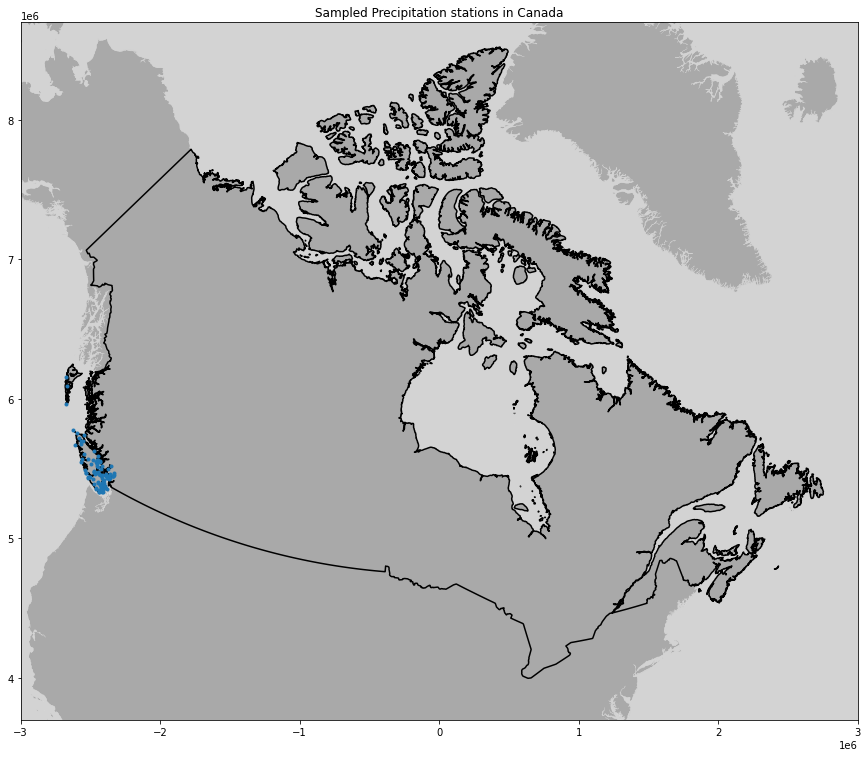

In [51]:
select_gdf_ = station_gdf.loc[valid_stns]
select_gdf_ = select_gdf_[select_gdf_['Source'] == 'EC']
select_gdf_ = select_gdf_.iloc[:n_samples, :]

plt.figure(figsize=(15,15))
ax = plt.gca() # Get Current Axes
ax.axis([-3000000,3000000,3700000,8700000])
geographic_features['ocean'].to_crs(aea_crs).plot(ax=ax, color='lightgrey')
geographic_features['land'].to_crs(aea_crs).plot(ax=ax, color='darkgrey')
canada_table.boundary.to_crs(aea_crs).plot(ax=ax, color='k')
select_gdf_.to_crs(aea_crs).plot(ax=ax, marker='.', zorder=10)
plt.title('Sampled Precipitation stations in Canada')

Text(0.5, 1.0, 'Sampled Precipitation stations in Canada')

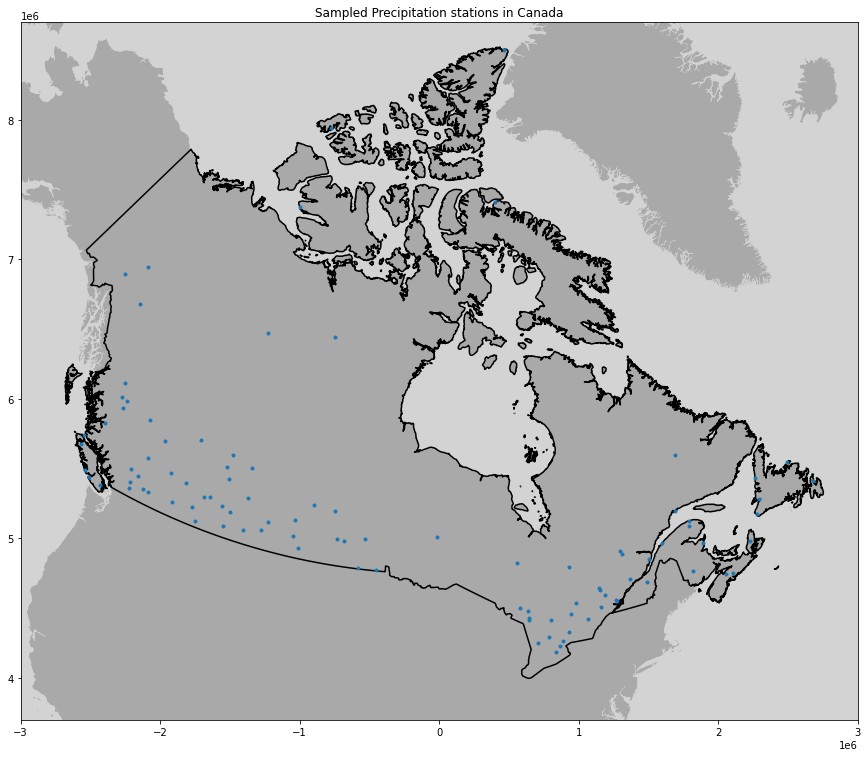

In [26]:
plt.figure(figsize=(15,15))
ax = plt.gca() # Get Current Axes
ax.axis([-3000000,3000000,3700000,8700000])
geographic_features['ocean'].to_crs(aea_crs).plot(ax=ax, color='lightgrey')
geographic_features['land'].to_crs(aea_crs).plot(ax=ax, color='darkgrey')
canada_table.boundary.to_crs(aea_crs).plot(ax=ax, color='k')
selected_gdf.to_crs(aea_crs).plot(ax=ax, marker='.', zorder=10)
plt.title('Sampled Precipitation stations in Canada')

#### Convert XArray to Dataframe

In [130]:
DS.prcp[select_idx, :]

<xarray.DataArray 'prcp' (station: 100, datetime: 14610)>
array([[ 0.083344,  0.      ,  0.      , ..., 17.85489 ,  0.      ,  0.      ],
       [ 5.026577,  0.      ,  0.      , ..., 36.880455,  0.      ,  0.384744],
       [ 0.      ,  0.      ,  0.      , ..., 18.565798,  0.      ,  0.      ],
       ...,
       [ 9.146834,  4.627752, 10.497428, ...,  3.826262,  0.      ,  1.761565],
       [ 0.      ,  0.773325,  0.      , ...,  7.003726,  0.      ,  0.      ],
       [ 2.661584,  0.477849, 10.118758, ...,  4.5     ,  0.      ,  0.      ]],
      dtype=float32)
Coordinates:
  * station    (station) <U13 'ECCA001022571' ... 'ECCA008501130'
  * datetime   (datetime) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    latitude   (station) float32 48.76 50.98 48.83 50.39 ... 47.78 47.77 53.56
    longitude  (station) float32 -123.77 -127.73 -125.12 ... -53.22 -64.09
    elevation  (station) float32 84.0 28.0 4.0 21.0 ... 11.8 10.1 42.7 439.5
Attributes:
    description:  SCD precipitation (mm/day)

In [101]:
precip_ = DS.prcp[select_idx, :]
precip_df = precip_.to_dataframe().reset_index()

tmin_ = DS.tmin[select_idx, :]
tmin_df = tmin_.to_dataframe().reset_index()

tmax_ = DS.tmax[select_idx, :]
tmax_df = tmax_.to_dataframe().reset_index()

full_df = pd.merge(
    precip_df, 
    pd.merge(tmax_df, tmin_df, on=['station','latitude', 'longitude', 'elevation', 'datetime']),
    on=['station','latitude', 'longitude', 'elevation', 'datetime']
)
full_df.set_index(['station','latitude', 'longitude', 'elevation', 'datetime'], inplace=True)

#### Filter out observations w/ little to no precipitation

In [102]:
precip_thresh = 1 # mm/day

In [103]:
full_df = full_df[full_df.prcp >= precip_thresh]

In [104]:
full_df

prcp  \
station       latitude  longitude   elevation datetime                
ECCA001022571 48.759998 -123.769997 84.0      1979-01-09   7.605373   
                                              1979-01-10   3.156929   
                                              1979-01-11   1.154405   
                                              1979-01-18   4.068577   
                                              1979-01-19  11.018023   
...                                                             ...   
ECCA008501130 53.560001 -64.089996  439.5     2018-12-22   7.500000   
                                              2018-12-23   1.000000   
                                              2018-12-24   1.500000   
                                              2018-12-28   1.000000   
                                              2018-12-29   4.500000   

                                                               tmax       tmin  
station       latitude  longitude   elevation datetime                          
ECCA001022571 48.759998 -123.769997 84.0      1979-01-09   1.421815  -3.629157  
                                              1979-01-10   1.413998  -0.593240  
                                              1979-01-11   3.775244  -0.563941  
                                              1979-01-18   4.378576  -1.125738  
                                              1979-01-19   4.912333   0.414051  
...                                                             ...        ...  
ECCA008501130 53.560001 -64.089996  439.5     2018-12-22   3.700000  -6.400000  
                                              2018-12-23  -6.300000 -19.700001  
                                              2018-12-24 -16.400000 -19.100000  
                                              2018-12-28 -16.200001 -26.900000  
                                              2018-12-29 -10.800000 -29.100000  

[446242 rows x 3 columns]

## Perform predictions

In [105]:
from sklearn.isotonic import IsotonicRegression 

In [106]:
ir_era5 = Load_Var('iso_t2m.data')

In [107]:
preds_iso = []
for i, j in zip(full_df['tmin'], full_df['tmax']):
    if i == j:
        preds_iso.append(
            np.mean(ir_era5.predict([i]))
        )
    else:
        vals = np.linspace(i, j, 100)
        preds = ir_era5.predict(vals)
        preds_iso.append(np.mean(preds))        


In [108]:
full_df['preds_iso'] = list(preds_iso)

In [109]:
Examine_Nulls(full_df)

column_name  percent_missing
prcp             prcp         0.000000
tmax             tmax         0.000000
tmin             tmin         0.000000
preds_iso   preds_iso         0.536704

In [114]:
full_df[np.isnan(full_df['preds_iso'])]

prcp       tmax  \
station       latitude  longitude   elevation datetime                          
ECCA001073615 54.400002 -126.669998 610.0     2012-01-19  2.000000 -21.500000   
ECCA001087974 53.869999 -125.870003 884.0     1979-01-15  1.356861 -22.165102   
                                              1979-12-15  2.268627 -20.281437   
                                              1980-01-10  6.900682 -22.621994   
                                              1982-02-14  4.180632 -11.647038   
...                                                            ...        ...   
ECCA008501130 53.560001 -64.089996  439.5     2013-01-17  2.053018  -7.441187   
                                              2013-02-02  1.117099 -23.092609   
                                              2013-02-04  3.670392 -18.212097   
                                              2017-02-08  2.921577 -18.497089   
                                              2018-01-27  1.878267 -10.750456   

                                                               tmin  preds_iso  
station       latitude  longitude   elevation datetime                          
ECCA001073615 54.400002 -126.669998 610.0     2012-01-19 -37.000000        NaN  
ECCA001087974 53.869999 -125.870003 884.0     1979-01-15 -39.594746        NaN  
                                              1979-12-15 -35.398510        NaN  
                                              1980-01-10 -35.592384        NaN  
                                              1982-02-14 -33.913429        NaN  
...                                                             ...        ...  
ECCA008501130 53.560001 -64.089996  439.5     2013-01-17 -34.860714        NaN  
                                              2013-02-02 -33.938370        NaN  
                                              2013-02-04 -34.708954        NaN  
                                              2017-02-08 -37.068108        NaN  
                                              2018-01-27 -34.743435        NaN  

[2395 rows x 4 columns]

In [110]:
filled_df = full_df.copy()
filled_df['tmid'] = filled_df.apply(
    lambda row: np.mean([row['tmin'], row['tmax']]), axis=1
)

def replace_nulls(x):
    if pd.isnull(x['preds_iso']) is True:
        if x['tmin'] > 0 and x['tmax'] > 0:
            return 0
        elif x['tmin'] < 0 and x['tmax'] < 0:
            return 1
        else: 
            if x['tmid'] < 0:
                return 1
            elif x['tmid'] > 0:
                return 0
    else:
        return x['preds_iso']
    

filled_df['filled_preds_iso'] = filled_df.apply(replace_nulls, axis=1)

In [111]:
Examine_Nulls(filled_df)

column_name  percent_missing
prcp                          prcp         0.000000
tmax                          tmax         0.000000
tmin                          tmin         0.000000
tmid                          tmid         0.000000
filled_preds_iso  filled_preds_iso         0.000000
preds_iso                preds_iso         0.536704

In [112]:
filled_df

prcp  \
station       latitude  longitude   elevation datetime                
ECCA001022571 48.759998 -123.769997 84.0      1979-01-09   7.605373   
                                              1979-01-10   3.156929   
                                              1979-01-11   1.154405   
                                              1979-01-18   4.068577   
                                              1979-01-19  11.018023   
...                                                             ...   
ECCA008501130 53.560001 -64.089996  439.5     2018-12-22   7.500000   
                                              2018-12-23   1.000000   
                                              2018-12-24   1.500000   
                                              2018-12-28   1.000000   
                                              2018-12-29   4.500000   

                                                               tmax  \
station       latitude  longitude   elevation datetime                
ECCA001022571 48.759998 -123.769997 84.0      1979-01-09   1.421815   
                                              1979-01-10   1.413998   
                                              1979-01-11   3.775244   
                                              1979-01-18   4.378576   
                                              1979-01-19   4.912333   
...                                                             ...   
ECCA008501130 53.560001 -64.089996  439.5     2018-12-22   3.700000   
                                              2018-12-23  -6.300000   
                                              2018-12-24 -16.400000   
                                              2018-12-28 -16.200001   
                                              2018-12-29 -10.800000   

                                                               tmin  \
station       latitude  longitude   elevation datetime                
ECCA001022571 48.759998 -123.769997 84.0      1979-01-09  -3.629157   
                                              1979-01-10  -0.593240   
                                              1979-01-11  -0.563941   
                                              1979-01-18  -1.125738   
                                              1979-01-19   0.414051   
...                                                             ...   
ECCA008501130 53.560001 -64.089996  439.5     2018-12-22  -6.400000   
                                              2018-12-23 -19.700001   
                                              2018-12-24 -19.100000   
                                              2018-12-28 -26.900000   
                                              2018-12-29 -29.100000   

                                                          preds_iso  \
station       latitude  longitude   elevation datetime                
ECCA001022571 48.759998 -123.769997 84.0      1979-01-09   0.828272   
                                              1979-01-10   0.671587   
                                              1979-01-11   0.371653   
                                              1979-01-18   0.384653   
                                              1979-01-19   0.188513   
...                                                             ...   
ECCA008501130 53.560001 -64.089996  439.5     2018-12-22   0.711139   
                                              2018-12-23   0.996846   
                                              2018-12-24   0.997986   
                                              2018-12-28   0.997987   
                                              2018-12-29   0.997958   

                                                               tmid  \
station       latitude  longitude   elevation datetime                
ECCA001022571 48.759998 -123.769997 84.0      1979-01-09  -1.103671   
                                              1979-01-10   0.410379   
                                              1979-01-11   1.605651   
            

Text(0.5, 1.0, 'SCDNA Isotonic Regression')

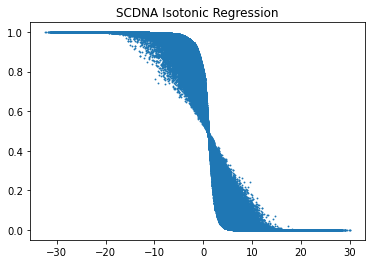

In [113]:
plt.scatter(filled_df['tmid'], preds_iso, s=0.7)
plt.title("SCDNA Isotonic Regression")

In [123]:
filled_df.to_csv("100_Stns_rand.csv")

#### testing something

In [125]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
preds_iso_ = []
for i, j in zip(full_df['tmin'], full_df['tmax']):
    vals = np.linspace(i, j, 100)
    preds = []
    for val in vals:
        pred = ir_era5.predict([val])
        if np.isnan(pred):
            if val > 0:
                preds.append(0)
            elif val < 0:
                preds.append(1)
            else: 
                if np.mean([i, j]) > 0:
                    preds.append(0)
                elif np.mean([i, j]) < 0:
                    preds.append(1)
        else:
            preds.append(pred)
    preds_iso_.append(np.mean(preds))
Save_Var(preds_iso, 'preds_iso_')

KeyboardInterrupt: 